<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_rf_interpretation_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import feather

ModuleNotFoundError: ignored

In [0]:
set_plot_sizes(12,14,16)

In [0]:
PATH = '/content/drive/generic_datasets/bulldozer/'

In [0]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [0]:
m = RandomForestRegressor(n_jobs=-1)

In [0]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [0]:
train_cats(df_raw)

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
??proc_df()

Object `proc_df` not found.


In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
set_rf_samples(50000)


In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20558593981067896, 0.24962454175503002, 0.9116672715524632, 0.8887186116611349, 0.8946567553532228]


In [0]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.41 s, sys: 100 ms, total: 1.51 s
Wall time: 1.52 s


(9.277666975383422, 0.2564652738004754)

In [0]:

def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 112 ms, sys: 147 ms, total: 259 ms
Wall time: 1.64 s


(9.277666975383422, 0.2564652738004754)

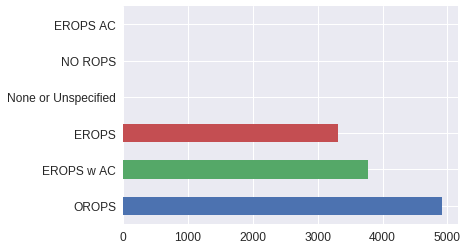

In [0]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [0]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.836989,0.279253
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577460,0.264176
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685943,0.225388


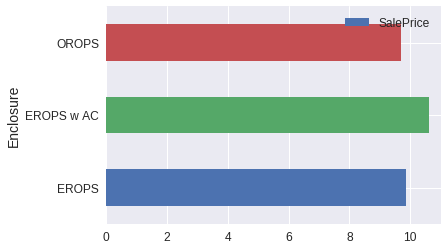

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

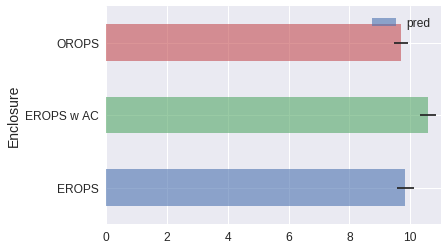

In [0]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));


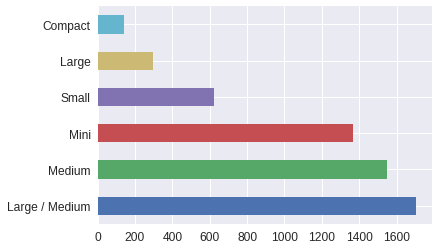

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();


In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.859701,0.327403
Large,10.470589,10.377311,0.385801
Large / Medium,10.691871,10.644253,0.294223
Medium,10.681511,10.618972,0.287185
Mini,9.535147,9.564829,0.246990
Small,10.324448,10.332839,0.309543


In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.037177
Compact           0.033206
Small             0.029957
Large / Medium    0.027642
Medium            0.027044
Mini              0.025823
dtype: float64

In [0]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170317
37,Coupler_System,0.119680
13,ProductSize,0.102404
14,fiProductClassDesc,0.078172
2,ModelID,0.054695
63,saleElapsed,0.050464
10,fiSecondaryDesc,0.045804
19,Enclosure,0.043151
38,Grouser_Tracks,0.042329
8,fiModelDesc,0.032540


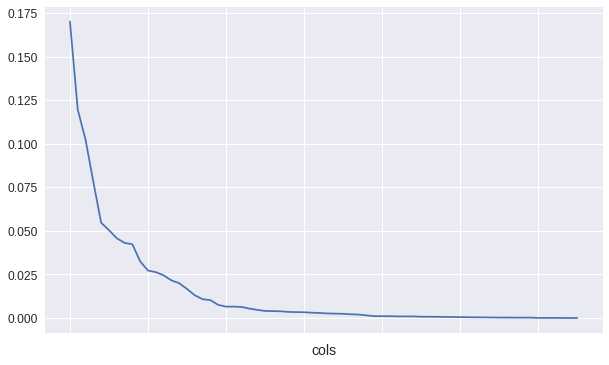

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

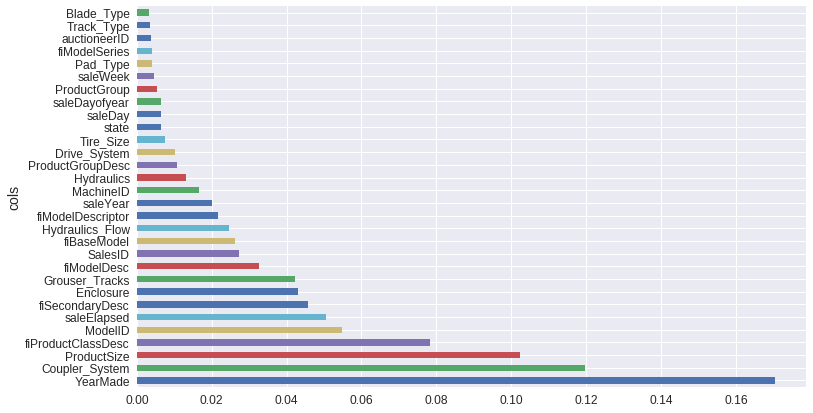

In [0]:
plot_fi(fi[:30])

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20611469556232662, 0.24499520584153694, 0.9112123133829889, 0.8928078094816307, 0.8949148028807326]


In [0]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20696449914266135, 0.24572765506080127, 0.9104786671291462, 0.8921659177448114, 0.8940583168213758]


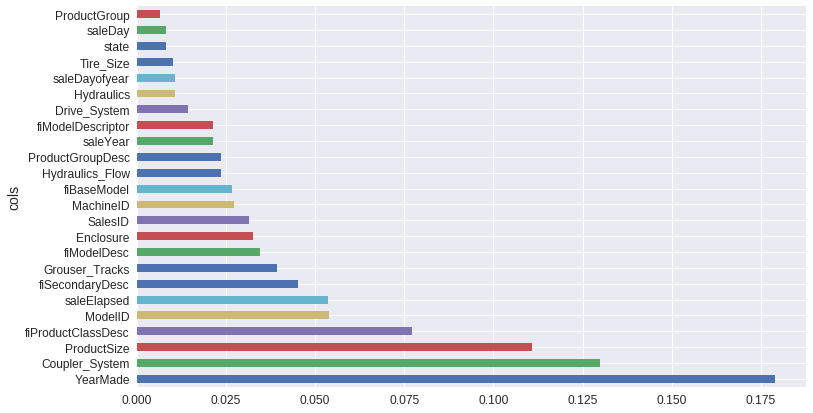

In [0]:

fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20680923624174455, 0.2535931642820714, 0.9106129329410373, 0.8851520997329426, 0.8929930059105822]


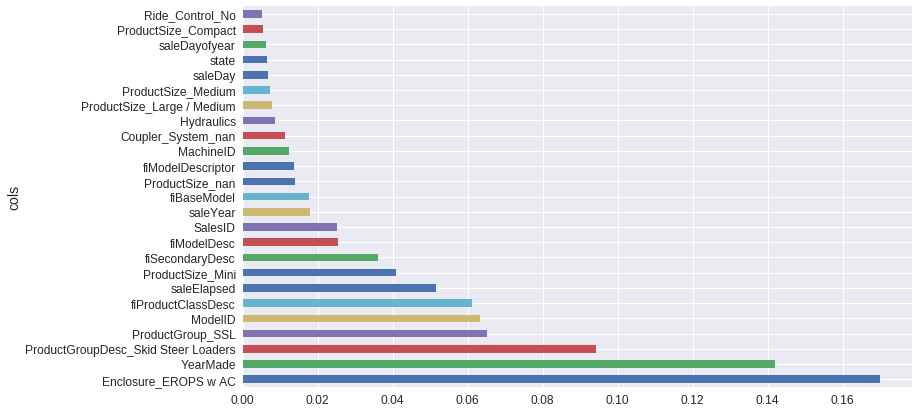

In [0]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [0]:
from scipy.cluster import hierarchy as hc

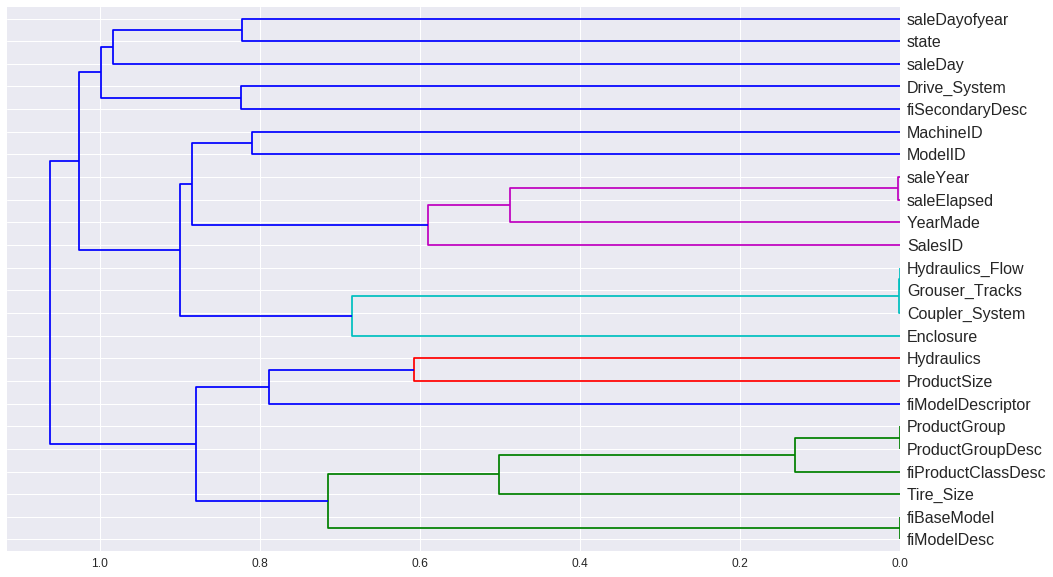

In [0]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [0]:
get_oob(df_keep)

0.8896874830483916

In [0]:

for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8898238579887698
saleElapsed 0.8866278714825115
fiModelDesc 0.8886352846725403
fiBaseModel 0.8893097527782023
Grouser_Tracks 0.8898980553372283
Coupler_System 0.8901159245616912


In [0]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8887849698471791

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('keep_cols.npy')
df_keep = df_trn[keep_cols]

In [0]:
reset_rf_samples()

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12562185669684398, 0.2273396962533231, 0.9670188919672575, 0.9077006750383244, 0.9087754623419881]


In [0]:

from pdpbox import pdp
from plotnine import *

In [0]:
set_rf_samples(50000)

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

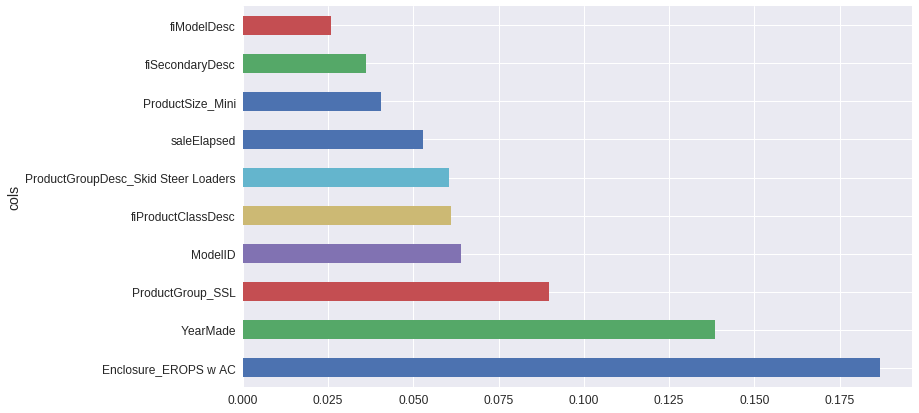

In [0]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


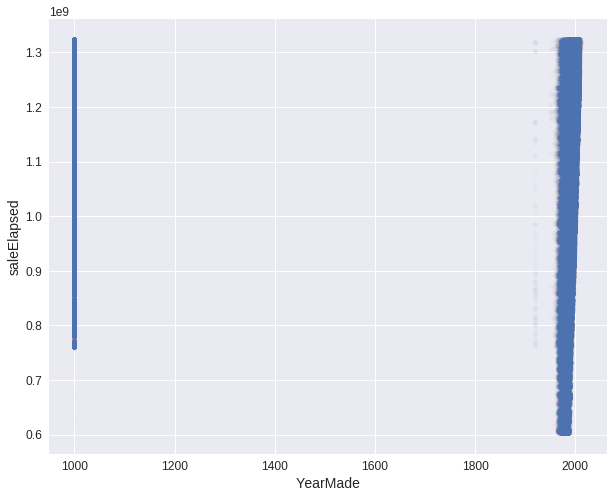

In [0]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [0]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

PlotnineError: ignored

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11ba3f4748>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11ba3c8cc0>})

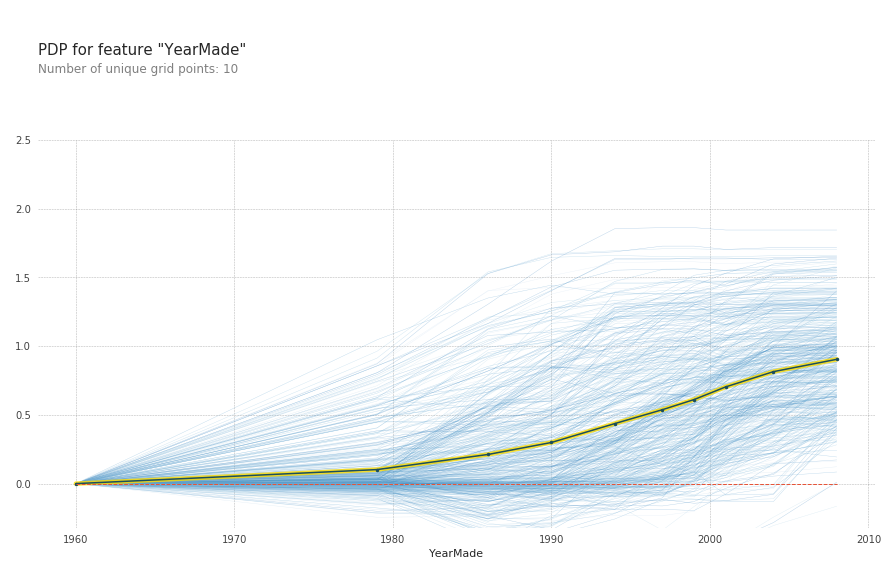

In [0]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11b5d53e48>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11b5cc3470>})

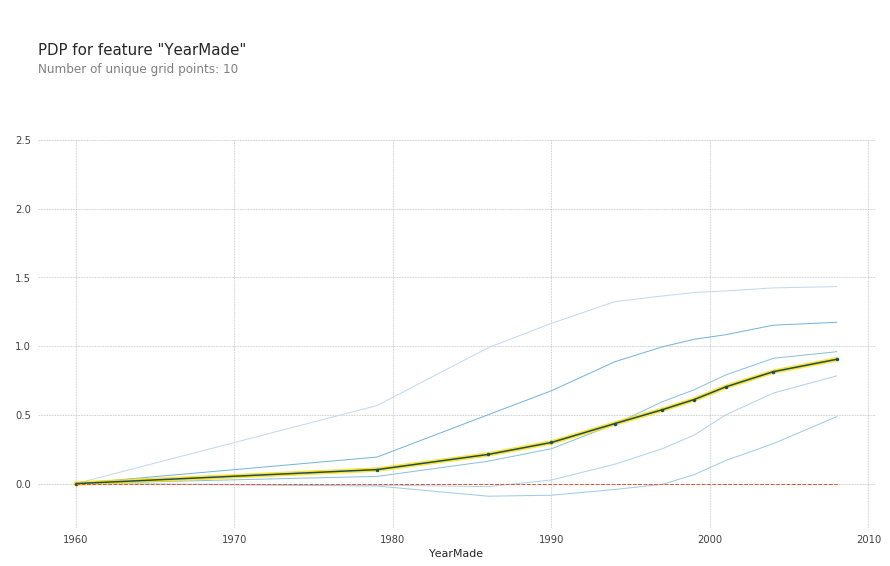

In [0]:
plot_pdp('YearMade', clusters=5)

TypeError: ignored

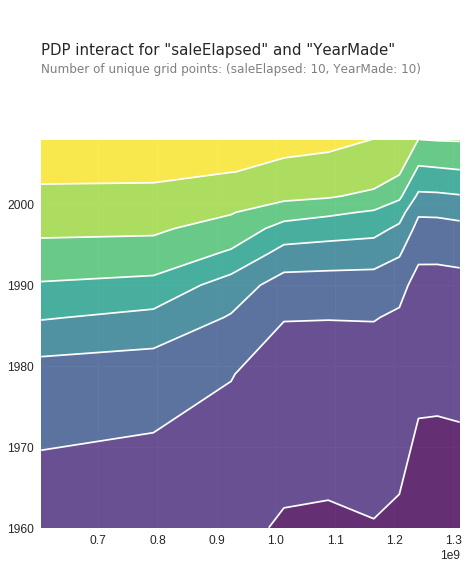

In [0]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11b99e2da0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f11b8ed6a20>})

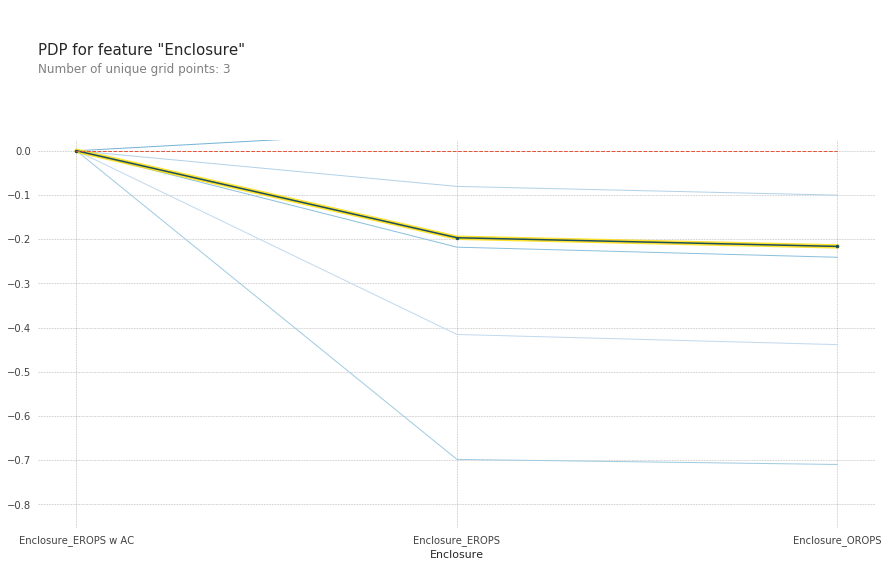

In [0]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

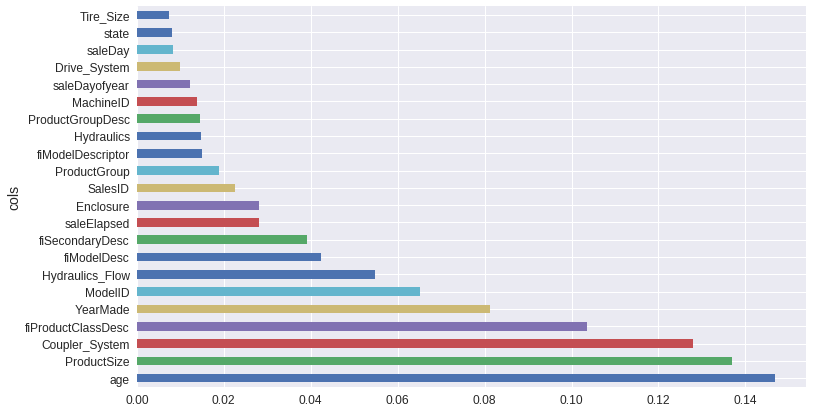

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [0]:
!pip3 install treeinterpreter

  Running setup.py bdist_wheel for treeinterpreter ... - done
  Stored in directory: /root/.cache/pip/wheels/38/b1/6c/b387910dc2f824718afabe17190498a0bebdaae6472f0c9197
Successfully built treeinterpreter


In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [0]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          1,
              3232,    4364751,          0,          0,    2300944,         12,          4,          0,
                 0,         35,         16,        259,          4,         11]])

In [0]:
prediction, bias, contributions = ti.predict(m, row)


In [0]:
prediction[0], bias[0]


(9.358213511043578, 10.105822948193545)

In [0]:
idxs = np.argsort(contributions[0])


In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.595425204442997),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.12049058351221302),
 ('age', 11, -0.09848515872797425),
 ('fiModelDesc', 'KX1212', -0.07575347560999575),
 ('fiSecondaryDesc', nan, -0.06070696193381044),
 ('Enclosure', 'EROPS', -0.030832329306024375),
 ('Tire_Size', nan, -0.013117686292404418),
 ('saleDayofyear', 259, -0.012736916178910106),
 ('fiModelDescriptor', nan, -0.01254518220976597),
 ('saleElapsed', 1284595200, -0.011306245844728346),
 ('saleDay', 16, -0.009691164931770446),
 ('state', 'Ohio', -0.005802565587812758),
 ('SalesID', 4364751, -0.003064549408695516),
 ('Drive_System', nan, 0.0038832822532406386),
 ('Hydraulics', 'Standard', 0.009770296178403281),
 ('ProductGroupDesc', 'Track Excavators', 0.015145034153886749),
 ('ProductGroup', 'TEX', 0.016213277955250537),
 ('Hydraulics_Flow', nan, 0.026404814295055833),
 ('ModelID', 665, 0.0279601647708299),
 ('Coupler_System', nan, 0.0605676569690

In [0]:
contributions[0].sum()

-0.747609437149966

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [0]:
fi = rf_feat_importance(m, x); fi[:10]


,cols,imp
9,SalesID,0.816858
5,saleElapsed,0.152865
12,MachineID,0.017881
8,fiModelDesc,0.003017
19,saleDayofyear,0.002290
0,YearMade,0.001962
1,Coupler_System,0.001117
7,Enclosure,0.001088
4,ModelID,0.000800
13,Hydraulics,0.000689


In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [0]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9786550327204737

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.232816
0,YearMade,0.178928
16,saleDayofyear,0.167377
4,ModelID,0.077382
7,fiModelDesc,0.062540
15,saleDay,0.059657
14,state,0.055997
3,fiProductClassDesc,0.032893
5,fiSecondaryDesc,0.024425
6,Enclosure,0.021715


In [0]:
set_rf_samples(50000)

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20751593701380888, 0.24721001762014888, 0.9100009888965985, 0.8908609660925941, 0.8934082264251428]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2093597362708614, 0.24680534972019758, 0.9083945840179815, 0.8912179816885244, 0.8922529565536905]
saleElapsed
[0.21442609602110205, 0.253775244999393, 0.9039073648264413, 0.8849871181931849, 0.8867811562023652]
MachineID
[0.20658221541789518, 0.24586113737337242, 0.9108090710633089, 0.8920487323009995, 0.8952503195126028]
age
[0.20921732708967702, 0.24826579885354386, 0.9085191639937902, 0.8899267563887446, 0.8919202826358438]
YearMade
[0.20854575319943905, 0.25011938198640277, 0.9091055163650954, 0.8882769796983239, 0.8927555205996796]
saleDayofyear
[0.2086764212396174, 0.24426150758872328, 0.9089915775796626, 0.8934488747561542, 0.8929960167584838]


In [0]:
reset_rf_samples()

In [0]:

df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13853511528598467, 0.21713434530512526, 0.9598898240587582, 0.9158013707731305, 0.9093423886525456]


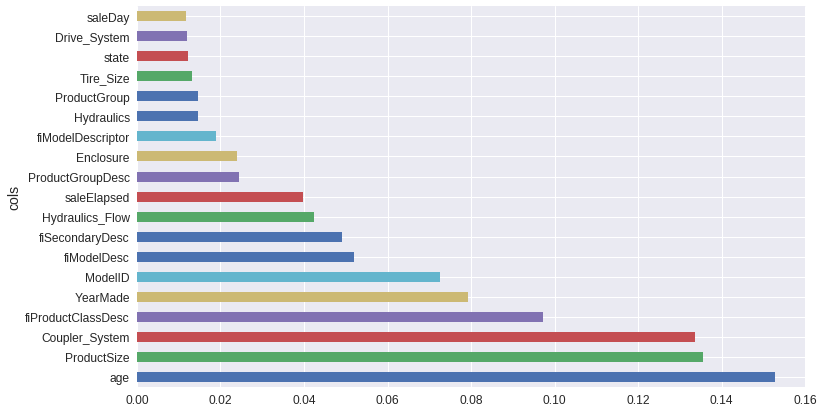

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('subs_cols.npy', np.array(df_subs.columns))

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 6s, sys: 3.18 s, total: 5min 10s
Wall time: 2min 43s
[0.08011813054085765, 0.21160963523177392, 0.9865848219816373, 0.9200315181827247, 0.9145955573037337]


In [0]:
from google.colab import files
files.download('subs_cols.npy')